In [44]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from pickle import dump
from unicodedata import normalize
import tinysegmenter
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [45]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()
    file.close()
    return text

def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

data = read_text("jpn.txt")
jpn_eng = to_lines(data)
jpn_eng = array(jpn_eng)
jpn_eng = jpn_eng[:10000,:]

jpn_eng

array([['Go.', '行け。'],
       ['Go.', '行きなさい。'],
       ['Hi.', 'こんにちは。'],
       ...,
       ['Tom kept his promise.', 'トムは約束を守った。'],
       ['Tom kicked Mary hard.', 'トムはメアリーを強く蹴った。'],
       ['Tom knocked him down.', 'トムは彼を殴り倒した。']], dtype='<U192')

In [46]:
jpn_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in jpn_eng[:,0]]
jpn_eng[:,0] = [jpn_eng[i,0].lower() for i in range(len(jpn_eng[:,0]))] 
jpn_eng

array([['go', '行け。'],
       ['go', '行きなさい。'],
       ['hi', 'こんにちは。'],
       ...,
       ['tom kept his promise', 'トムは約束を守った。'],
       ['tom kicked mary hard', 'トムはメアリーを強く蹴った。'],
       ['tom knocked him down', 'トムは彼を殴り倒した。']], dtype='<U192')

In [47]:
jpn_eng[:,1] = [" ".join(tinysegmenter.tokenize(i)[:-1]) for i in jpn_eng[:,1]]
jpn_eng

array([['go', '行け'],
       ['go', '行き なさい'],
       ['hi', 'こん にち は'],
       ...,
       ['tom kept his promise', 'トム は 約束 を 守っ た'],
       ['tom kicked mary hard', 'トム は メアリー を 強く 蹴っ た'],
       ['tom knocked him down', 'トム は 彼 を 殴り倒し た']], dtype='<U192')

In [48]:
np.random.shuffle(jpn_eng)
jpn_eng

array([['dont look at me', 'こっち 見 ない でく ださい'],
       ['it seems probable', 'それ が 起こり そう だ'],
       ['they won the day', '彼ら は 勝っ た'],
       ...,
       ['ill give you a ride', '車 で 送っ て いっ て あげる よ'],
       ['stop gambling', '賭け事 は やめ なさい'],
       ['calm down', '落ち着け']], dtype='<U192')

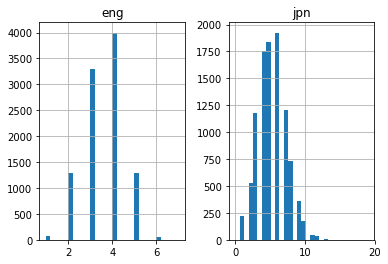

In [49]:
eng_l = []
jpn_l = []

# populate the lists with sentence lengths
for i in jpn_eng[:,0]:
      eng_l.append(len(i.split()))

for i in jpn_eng[:,1]:
      jpn_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'jpn':jpn_l})
# print(length_df)

length_df.hist(bins = 30)
plt.show()

In [50]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [51]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [52]:
eng_tokenizer = tokenization(jpn_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = max_length(jpn_eng[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 2760


In [53]:
jpn_tokenizer = tokenization(jpn_eng[:, 1])
jpn_vocab_size = len(jpn_tokenizer.word_index) + 1

jpn_length = max_length(jpn_eng[:, 1])
print('Japanese Vocabulary Size: %d' % jpn_vocab_size)

Japanese Vocabulary Size: 4723


In [54]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [55]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(jpn_eng, test_size=0.2, random_state = 12)

In [56]:
# prepare training data
trainX = encode_sequences(jpn_tokenizer, jpn_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(jpn_tokenizer, jpn_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [57]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [58]:
model = define_model(jpn_vocab_size, eng_vocab_size, jpn_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [59]:
filename = 'jpn_model2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 86s 13ms/step - loss: 6.4905 - val_loss: 4.2466

Epoch 00001: val_loss improved from inf to 4.24657, saving model to jpn_model2.h5
Epoch 2/10
6400/6400 [==============================] - 87s 14ms/step - loss: 3.8290 - val_loss: 3.7389

Epoch 00002: val_loss improved from 4.24657 to 3.73888, saving model to jpn_model2.h5
Epoch 3/10
6400/6400 [==============================] - 87s 14ms/step - loss: 3.5343 - val_loss: 3.4995

Epoch 00003: val_loss improved from 3.73888 to 3.49948, saving model to jpn_model2.h5
Epoch 4/10
6400/6400 [==============================] - 84s 13ms/step - loss: 3.3205 - val_loss: 3.3113

Epoch 00004: val_loss improved from 3.49948 to 3.31128, saving model to jpn_model2.h5
Epoch 5/10
6400/6400 [==============================] - 88s 14ms/step - loss: 3.1560 - val_loss: 3.2131

Epoch 00005: val_loss improved from 3.31128 to 3.21306, saving model to jpn_model2.h5
E

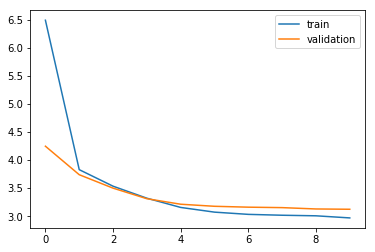

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [61]:
model = load_model('jpn_model2.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [62]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [63]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [64]:
pred_df = pd.DataFrame({'jap':test[:,1],'actual' : test[:,0], 'predicted' : preds_text})

In [65]:
pred_df.sample(15)

,jap,actual,predicted
1905,私 の 工具 箱 を 持っ て き て,get my tool box,i is
354,リラックス し て いい よ,you can relax,i is
1419,弟 の です,its my brothers,i is
731,僕 は 黙ら ない ぞ,i wont be quiet,i is
770,少々 お 待ち下さい,please wait a minute,i is
1672,あなた の 友達っ て 誰,whos your friend,i is
407,ドア を 閉め て,shut the door,i is
1325,トム は おしゃべり だ,tom is talkative,i is
616,夏 は どう だっ た,how was your summer,i is
1397,もう １ 度 やっ て み なさい,try it again,i is


In [ ]:
model = load_model('jpn_model1.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))
    
pred_df = pd.DataFrame({'jap':test[:,1],'actual' : test[:,0], 'predicted' : preds_text})
pred_df.sample(15)

In [48]:
testX

array([[1417,    7,  104, ...,   18,    0,    0],
       [ 443,    1, 2925, ...,    3,   20,   17],
       [  20,  418,    1, ...,   37,   17,   14],
       ...,
       [3551, 3552,    7, ...,    3,   20,   17],
       [2353,    7,  273, ...,    0,    0,    0],
       [   8,    1, 2602, ...,    0,    0,    0]])